In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!chmod 755 -R /content/drive/MyDrive/virtual_env/bin

In [ ]:
!source /content/drive/MyDrive/virtual_env/bin/activate; pip install scanpy

In [ ]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [ ]:
from adjustText import adjust_text
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sys
from glob import iglob
from scipy import sparse
from scipy.sparse import coo_matrix
import math

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.25.2 scipy==1.13.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.10.8 pynndescent==0.5.11


In [ ]:
# the directory with the DE gene files

input_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/chimp"
output_fig_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/chimp"
output_dir="/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/chimp"
de_gene_dir="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/chimp"
input_DE_dir ="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/chimp"
sc.settings.figdir = output_dir

In [ ]:
#create gene set with significant DE gene results
subdir_list = ['exc_subclass','inh_subclass','nn_subclass']

for subdir in subdir_list:

 for file in os.listdir(os.path.join(input_dir,subdir)):
  #find GSEA gene output txt file
  subclass = ""
  if file.endswith("_Cov.csv"):
    subclass = file[5:file.find("_limmatrend")]
    print(subclass)
    gsea_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    #print(gsea_df[[1,2,3,4,5,6]])
    if "highlighted" not in gsea_df.columns :
      gsea_df = gsea_df[gsea_df['adjusted_p_value']<0.01]
    else:
      #print(gsea_df)
      gsea_df = gsea_df[gsea_df['highlighted']==True]
    print(gsea_df.shape)
    gsea_df.replace("",np.nan,inplace=True)
    gsea_df.dropna(axis="columns",how="all",inplace=True)
    gsea_df.to_csv(os.path.join(output_dir,subdir,subclass+"_gsea_sig.tsv"),sep="\t",index=False)
    genes_sel = gsea_df.columns[10:]
    pd.DataFrame({'gene':genes_sel}).to_csv(os.path.join(output_dir,subdir,subclass+"_genes_sel.tsv"),sep="\t",index=False)
    #print(genes_sel)


In [ ]:
#check if there is overlap between gene sets
subclass_genelist = dict()

gene_set_total = []

#for subdir in subdir_list:
subdir = 'exc_subclass'
for file in os.listdir(os.path.join(input_dir,subdir)):
  #find DE gene set txt file
  subclass = ""
  if file.endswith("_genes_sel.tsv"):
    subclass = file[0:file.find("_genes_sel.tsv")]
    #print(subclass)
    gene_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    gene_list = gene_df['gene'].tolist()
    subclass_genelist[subclass] = gene_list
    gene_set_total.extend(gene_list)
    #print(gene_list)


uniq_genes_total = np.unique(gene_set_total)
print(len(uniq_genes_total))
ovp_genes = []

for key, value in subclass_genelist.items():
  for key2, value2 in subclass_genelist.items():
    if key != key2:
      size = min(len(value),len(value2))
      print(key + ":" + str(len(value)) + " , " + key2 + ":" + str(len(value2)) + " , " + str(len(set(value).intersection(set(value2)))) + " , " + str(len(set(value).intersection(set(value2)))/size))
      ovp = set(value).intersection(set(value2))
      ovp_genes.extend(ovp)
      #print(ovp)
      #print(len(ovp))
      #print(set(value).intersection(set(value2)))

uniq_genes_ovp = np.unique(ovp_genes)
print(len(uniq_genes_ovp))
remain_genes = list(set(uniq_genes_total).difference(set(uniq_genes_ovp)))
print(len(remain_genes))
for key, value in subclass_genelist.items():
  print(key + ":" + str(len(value)) + " , " + str(len(set(value).intersection(set(remain_genes)))))

pd.DataFrame({'gene':remain_genes}).to_csv(os.path.join(output_dir,subdir+"_genes_remove_dup.tsv"),sep="\t",index=False)

In [ ]:
#check if there is overlap between gene sets
subclass_genelist = dict()
#subdir_list = ['exc_subclass','inh_subclass','nn_subclass']
gene_set_total = []

#for subdir in subdir_list:
subdir = 'inh_subclass'
for file in os.listdir(os.path.join(input_dir,subdir)):
  #find GSEA gene set txt file
  subclass = ""
  if file.endswith("_genes_sel.tsv"):
    subclass = file[0:file.find("_genes_sel.tsv")]
    #print(subclass)
    gene_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    gene_list = gene_df['gene'].tolist()
    subclass_genelist[subclass] = gene_list
    gene_set_total.extend(gene_list)
    #print(gene_list)


uniq_genes_total = np.unique(gene_set_total)
print(len(uniq_genes_total))
ovp_genes = []

for key, value in subclass_genelist.items():
  for key2, value2 in subclass_genelist.items():
    if key != key2:
      size = min(len(value),len(value2))
      print(key + ":" + str(len(value)) + " , " + key2 + ":" + str(len(value2)) + " , " + str(len(set(value).intersection(set(value2)))) + " , " + str(len(set(value).intersection(set(value2)))/size))
      ovp = set(value).intersection(set(value2))
      ovp_genes.extend(ovp)
      #print(ovp)
      #print(len(ovp))
      #print(set(value).intersection(set(value2)))

uniq_genes_ovp = np.unique(ovp_genes)
print(len(uniq_genes_ovp))
remain_genes = list(set(uniq_genes_total).difference(set(uniq_genes_ovp)))
print(len(remain_genes))
for key, value in subclass_genelist.items():
  print(key + ":" + str(len(value)) + " , " + str(len(set(value).intersection(set(remain_genes)))))

pd.DataFrame({'gene':remain_genes}).to_csv(os.path.join(output_dir,subdir+"_genes_remove_dup.tsv"),sep="\t",index=False)

In [ ]:
#check if there is overlap between gene sets
subclass_genelist = dict()
#subdir_list = ['exc_subclass','inh_subclass','nn_subclass']
gene_set_total = []

#for subdir in subdir_list:
subdir = 'nn_subclass'
for file in os.listdir(os.path.join(input_dir,subdir)):
  #find GSEA gene set txt file
  subclass = ""
  if file.endswith("_genes_sel.tsv"):
    subclass = file[0:file.find("_genes_sel.tsv")]
    #print(subclass)
    gene_df = pd.read_csv(os.path.join(input_dir,subdir,file),sep=",",header=0,index_col=False)
    gene_list = gene_df['gene'].tolist()
    subclass_genelist[subclass] = gene_list
    gene_set_total.extend(gene_list)
    #print(gene_list)


uniq_genes_total = np.unique(gene_set_total)
print(len(uniq_genes_total))
ovp_genes = []

for key, value in subclass_genelist.items():
  for key2, value2 in subclass_genelist.items():
    if key != key2:
      size = min(len(value),len(value2))
      print(key + ":" + str(len(value)) + " , " + key2 + ":" + str(len(value2)) + " , " + str(len(set(value).intersection(set(value2)))) + " , " + str(len(set(value).intersection(set(value2)))/size))
      ovp = set(value).intersection(set(value2))
      ovp_genes.extend(ovp)
      #print(ovp)
      #print(len(ovp))
      #print(set(value).intersection(set(value2)))

uniq_genes_ovp = np.unique(ovp_genes)
print(len(uniq_genes_ovp))
remain_genes = list(set(uniq_genes_total).difference(set(uniq_genes_ovp)))
print(len(remain_genes))
for key, value in subclass_genelist.items():
  print(key + ":" + str(len(value)) + " , " + str(len(set(value).intersection(set(remain_genes)))))

pd.DataFrame({'gene':remain_genes}).to_csv(os.path.join(output_dir,subdir+"_genes_remove_dup.tsv"),sep="\t",index=False)

In [ ]:
#select top 5 genes from the DE analysis for each cell type
input_DE_dir ="/content/drive/MyDrive/LeoDai/Private_Data/DE_genes/chimp"


In [ ]:
subdir = "inh_subclass"

DE_genes = []
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  #find DE output txt file
  subclass = ""
  if file.endswith("_Cov.tsv"):
    subclass = file[0:file.find("_limmatrend")]
    print(subclass)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = 'gene'

    #print(de_genes_df)
    de_genes_sel = de_genes_df[(de_genes_df['adj.P.Val']<0.05) & (2**de_genes_df['logFC'] >= 1.4)]
    #print(de_genes_sel)
    DE_genes.extend(de_genes_sel.index)
    pd.DataFrame({'gene':de_genes_sel.index}).to_csv(os.path.join(input_DE_dir,subdir,subclass+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)
    #print(genes_sel)

DE_genes = np.unique(DE_genes)
print(len(DE_genes))
pd.DataFrame({'gene':DE_genes}).to_csv(os.path.join(input_DE_dir,subdir+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)


In [ ]:
subdir = "exc_subclass"
celldir = "exc_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
celltype = file[0:file.find("_limmatrend")]
celltype_list.append(celltype)
for file in os.listdir(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv"):
    celltype_name_list = file[0:file.find("_limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)-1])
    print(celltype)


In [ ]:
subdir = "exc_subclass"
celldir = "exc_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

for file in os.listdir(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv") and "L6_CT" not in file:
    celltype_name_list = file[0:file.find("_limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)-1])

    print(celltype)
    print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4",file),sep="\t",header=0,index_col=False)

    DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)


In [ ]:
subdir = "inh_subclass"
celldir = "inh_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

DE_genes['SNCG_VIP'] = []
DE_genes['MEIS2'] = []
for file in os.listdir(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv"):
    celltype_name_list = file[0:file.find("_limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)-1])

    print(celltype)
    print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4",file),sep="\t",header=0,index_col=False)

    DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)


In [ ]:
subdir = "nn_subclass"
celldir = "nn_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []


for file in os.listdir(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4")):
  #find cell type top DE gene output txt file
  if file.endswith("top_gene_adjPval05_FC1.4.tsv"):
    celltype_name_list = file[0:file.find("_limmatrend")].split("_")
    celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    print(celltype)
    print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,"sigDE","adjPval05FC1.4",file),sep="\t",header=0,index_col=False)
    for key in DE_genes.keys():
      if celltype.startswith(key):
        DE_genes[key].extend(de_genes_df.gene)
    #DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",index=False)


In [ ]:
#top 5 DE genes
subdir = "nn_subclass"
celldir = "nn_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []


for file in os.listdir(os.path.join(input_DE_dir,celldir)):
  #find cell type top DE gene output txt file
  if file.endswith("Cov.txt"):
    celltype = file[0:file.find("_limmatrend")]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    print(celltype)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,file),sep="\t",header=0,index_col=0)
    #de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if celltype.startswith(key):
        DE_genes[key].extend(de_genes_df.index[0:5])
    #DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  if key != "VLMC" :
    adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_nn_"+key+"_raw_filt_norm_subclass.h5ad"))
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print(adata)
    sc.pl.dotplot(adata, var_names=np.unique(value), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)
    plt.savefig(os.path.join(input_DE_dir,"chimp_dotplot"+key+"_by_DE_top5_genes.png"))

print(adata)

In [ ]:
#top 5 DE genes
subdir = "inh_subclass"
celldir = "inh_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []


for file in os.listdir(os.path.join(input_DE_dir,celldir)):
  #find cell type top DE gene output txt file
  if file.endswith("Cov.txt"):
    celltype = file[0:file.find("_limmatrend")]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    print(celltype)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,file),sep="\t",header=0,index_col=0)
    #de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if celltype.startswith(key):
        DE_genes[key].extend(de_genes_df.index[0:5])
    #DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  if key != "SNCG_VIP" and key != "SST_CHODL" :
    adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_inh_"+key+"_raw_filt_norm_subclass.h5ad"))
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print(adata)
    sc.pl.dotplot(adata, var_names=np.unique(value), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)
    plt.savefig(os.path.join(input_DE_dir,"chimp_dotplot"+key+"_by_DE_top5_genes.png"))

In [ ]:
#top 5 DE genes
subdir = "exc_subclass"
celldir = "exc_celltype"

DE_genes = dict()
celltype_list = []

for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("_limmatrend")]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []


for file in os.listdir(os.path.join(input_DE_dir,celldir)):
  #find cell type top DE gene output txt file
  if file.endswith("Cov.txt"):
    celltype = file[0:file.find("_limmatrend")]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    print(celltype)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,file),sep="\t",header=0,index_col=0)
    #de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if celltype.startswith(key):
        DE_genes[key].extend(de_genes_df.index[0:5])
    #DE_genes[celltype].extend(de_genes_df.gene)

for key, value in DE_genes.items():
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)

  if key != "L5_L23" and key != "Novel":
    adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    print(adata)
    sc.pl.dotplot(adata, var_names=np.unique(value), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)
    plt.savefig(os.path.join(input_DE_dir,"chimp_dotplot"+key+"_by_DE_top5_genes.png"))

In [ ]:
#reclustering L2_L3_IT, L5_IT, L6_IT, L6_IT_Car3, L6_CT
#read in all GSEA genes
subclass = "exc_subclass"
L2_3_IT_genes = pd.read_csv(os.path.join(input_dir,subclass,"L2_L3_IT_genes_sel.tsv"),sep="\t",header=0,index_col=0)
L5_IT_genes = pd.read_csv(os.path.join(input_dir,subclass,"L5_IT_genes_sel.tsv"),sep="\t",header=0,index_col=0)
L6_IT_genes = pd.read_csv(os.path.join(input_dir,subclass,"L6_IT_genes_sel.tsv"),sep="\t",header=0,index_col=0)
L6_IT_Car3_genes = pd.read_csv(os.path.join(input_dir,subclass,"L6_IT_Car3_genes_sel.tsv"),sep="\t",header=0,index_col=0)
L6_CT_genes = pd.read_csv(os.path.join(input_dir,subclass,"L6_CT_genes_sel.tsv"),sep="\t",header=0,index_col=0)
novel_genes = pd.read_csv(os.path.join(input_dir,subclass,"novel_genes_sel.tsv"),sep="\t",header=0,index_col=0)

genes = pd.concat([L2_3_IT_genes,L5_IT_genes,L6_IT_genes,L6_IT_Car3_genes,L6_CT_genes,novel_genes])
L2_3_IT_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L2_L3_IT_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L5_IT_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L5_IT_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L6_IT_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L6_IT_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L6_IT_Car3_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L6_IT_Car3_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L6_CT_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L6_CT_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
novel_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"Novel_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L5_L23_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L5_L23_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L5_ET_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L5_ET_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L5_NP_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L5_NP_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L5_6NP_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L5_6NP_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L6_ET_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L6_ET_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)
L6b_genes = pd.read_csv(os.path.join(input_DE_dir,subclass,"L6b_DE_genes_adjPval05_FC1.4.tsv"),sep="\t",header=0,index_col=0)

genes = pd.concat([genes,L5_ET_genes,L5_L23_genes,L2_3_IT_genes,L5_IT_genes,L6_IT_genes,L6_IT_Car3_genes,L6_CT_genes,novel_genes,L6b_genes,L6_ET_genes,L5_6NP_genes,L5_NP_genes,])
#print(genes)
#genes.index
gsea_genes = list(genes.index.unique())
if "RORA" not in gsea_genes:
  gsea_genes.append("RORA")
if "SEMA5A" not in gsea_genes:
  gsea_genes.append("SEMA5A")
if "TLE4" not in gsea_genes:
  gsea_genes.append("TLE4")
if "ETV1" not in gsea_genes:
  gsea_genes.append("ETV1")

gsea_genes.append("NEFH")
gsea_genes.append("FOXP1")
gsea_genes.append("RELN")
gsea_genes.append("OTOGL")
gsea_genes.append("COL22A1")
gsea_genes.append("CNR1")

gsea_genes = np.unique(gsea_genes)
print(len(gsea_genes))
#print(gsea_genes)


885


In [ ]:
L2_3_IT = ["CUX2","TAFA1"] #Intratelencephalic projecting
L5_ET = ["FEZF2"] #LOC105376457, OR51E2 marker of extratelencephalic
L5_IT = ["RORB","POU6F2"] # LOC105374971 and CUX2 and TAFA1 and no HS3ST2
L5_6NP = ["PHLDB2", "TLL1"] # NPSR1_AS1 near projecting
L6_CT = ["SEMA5A","SEMA3E"] #EGFEM1P
L6_IT_Car3 =["ATP10A","RGS12","PDE7B"] # RGS12 KLHL1
L6_IT =["THEMIS","PDE7B","RGS20"] #LINC00343, LOC101928278 RGS20
L6b = ["MDFIC","NPFFR2"]
L5_NP = ["PHLDB2"]
#L4 marker RORB
marker_genes = L2_3_IT + L5_ET + L5_IT + L5_6NP + L6_CT + L6_IT_Car3 + L6_IT + L6b + L5_NP

marker_genes.append("KLHL1")
marker_genes.append("TLL1")
marker_genes.append("HS3ST2")
marker_genes.append("LAMP5")
marker_genes.append("PDGFD")
marker_genes.append("FOLH1B")
marker_genes.append("FNBP1L")
marker_genes.append("GSG1L")
marker_genes.append("CRYBG3")
marker_genes.append("CARM1P1")
marker_genes.append("COL22A1")
marker_genes.append("ESR1")
marker_genes.append("FILIP1L")
marker_genes.append("TWIST2")
marker_genes.append("SCN4B")
marker_genes.append("DAPK2")
marker_genes.append("FOLH1B")
marker_genes.append("IL26")
marker_genes.append("CNR1")
marker_genes.append("C1R")

glist = ['CHST9','FAM19A1','FBN2','PIEZO2','HTR2A','POU6F2','RORB','CHRM2','PHLDB2','HS3ST4','SEMA3E','NTNG2','PTPRU','CLSTN2','HS3ST5','PDE7B',
         'SLIT3','ARSJ','THSD4']

marker_genes.extend(glist)
gsea_genes = list(gsea_genes)
#print(gsea_genes)
for g in marker_genes:
  #print(g)
  if g not in gsea_genes:
    gsea_genes.append(g)
gsea_genes = np.unique(gsea_genes)
#print(len(gsea_genes))
#print(gsea_genes)
'''
#IT cells
L5_6NP = ["33","47"]
L6_IT_Car3 = ["32","34"] #PDE7B and ATP10A
L6b = ["15","43"] #NPFFR2 and SEMA5A
L6_CT = ["0","7","10"]
#L6_CT = ["31","41"] # SEMA3E
L5_IT = ["5","6","16","30","38","40","42"]
L5_NP = ["13","21"] # add PHLDB2 and no HS3ST2 no TLL1
L5_ET = ["2","17","26","27","37","49","50"] #50 specific cell
L5_ET_sub20 = ["20"] #a separate cell type
L5_ET_sub8 = ["8"] #a separate cell type
L5_L23 = ["46"]
L6_ET = ["3","24"]
L6_IT =  ["4","12","18","19","23","25","29","44","45"] #RGS20
L2_L3_IT = ["1","9","11","14","22","28","35","36","39"] #Intratelencephalic projecting
Noval_1 = ["31"]
Noval_2 = ["41"]
''''''

'''



In [ ]:
adata=sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_cell_types_raw_filt_norm_subclass.h5ad"))
adata

AnnData object with n_obs × n_vars = 56322 × 20189
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
def myfunc(x):
  if x != "":
    return x
  else:
    return "Novel_3"

adata.obs['subclass'] = adata.obs['subclass'].apply(lambda x: myfunc(x))

adata.obs.subclass.value_counts()

subclass
L2_L3_IT      11544
L6_IT          9728
L5_ET          9409
L5_IT          7343
L6_CT          6033
L6_ET          3157
L5_NP          2692
L6b            1888
L6_IT_Car3     1649
L5_6NP         1052
Noval_1         856
Noval_2         562
L5_L23          229
Novel_3         180
Name: count, dtype: int64

In [ ]:
#subclass_list = ["L2_L3_IT","L6_IT","L5_IT","L6_IT_Car3","L6_CT","L5_L23","Novel_3"]
#adata_exc_IT = adata[adata.obs.subclass.isin(subclass_list),:]
adata_exc_IT = adata

In [ ]:
#normalize to 10000 reads, log transformed,
sc.pp.normalize_total(adata_exc_IT, target_sum=1e4)
sc.pp.log1p(adata_exc_IT)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
#regress out
sc.pp.regress_out(adata_exc_IT, ['total_counts', 'pct_counts_mt','pct_counts_ribo'])
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata_exc_IT, max_value=10)

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:19:07)


In [ ]:
adata_exc_IT.write_h5ad(os.path.join(input_DE_dir,"chimp_exc_cell_types_raw_filt_norm_regress_subclass.h5ad"), compression="gzip")

In [ ]:
adata_exc_IT = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_cell_types_raw_filt_norm_regress_subclass.h5ad"))

In [ ]:
adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_cell_types_raw_filt_norm_regress_subclass.h5ad"))

In [ ]:
if "HTR2A" in adata.var_names:
  print("HTR2A")

HTR2A


In [ ]:
#print(gsea_genes)
adata_exc_IT = adata_exc_IT[:,adata_exc_IT.var_names.isin(gsea_genes)]
adata_exc_IT

View of AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p'

computing PCA
    with n_comps=50


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


    finished (0:00:03)


2024-06-08 01:33:54,358 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2024-06-08 01:34:09,925 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2024-06-08 01:34:10,232 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2024-06-08 01:34:33,352 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2024-06-08 01:34:56,281 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2024-06-08 01:35:18,713 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2024-06-08 01:35:27,351 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2024-06-08 01:35:34,464 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2024-06-08 01:35:41,941 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


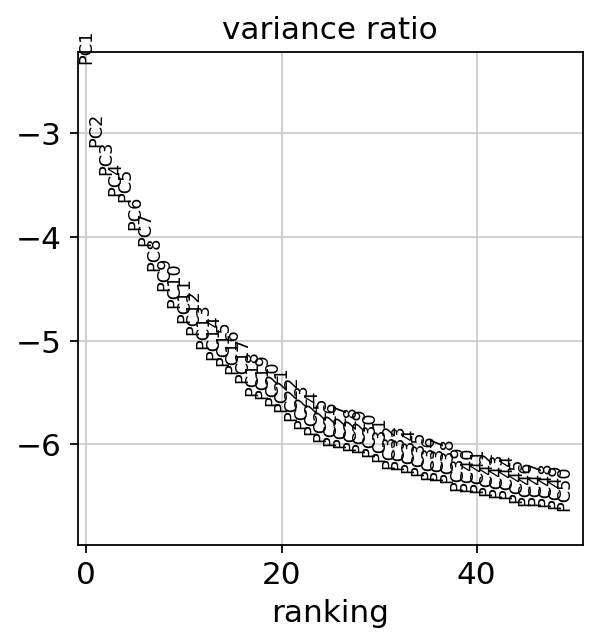

In [ ]:
sc.tl.pca(adata_exc_IT, svd_solver='arpack')

sc.pl.pca_variance_ratio(adata_exc_IT, log=True,show=False,n_pcs=50)
plt.savefig(os.path.join(output_dir,"adata_exc_IT_pca_var_ratio.png"))
#batch correction
sc.external.pp.harmony_integrate(adata_exc_IT, 'sample')
#replcae PCA by the batch corrected data
adata_exc_IT.obsm['X_pca'] = adata_exc_IT.obsm['X_pca_harmony']

In [ ]:
#create the neighborhood graph and calculate the connectivities
sc.pp.neighbors(adata_exc_IT, n_neighbors=10, n_pcs=50)
sc.tl.leiden(adata_exc_IT, resolution=0.5)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:49)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>]

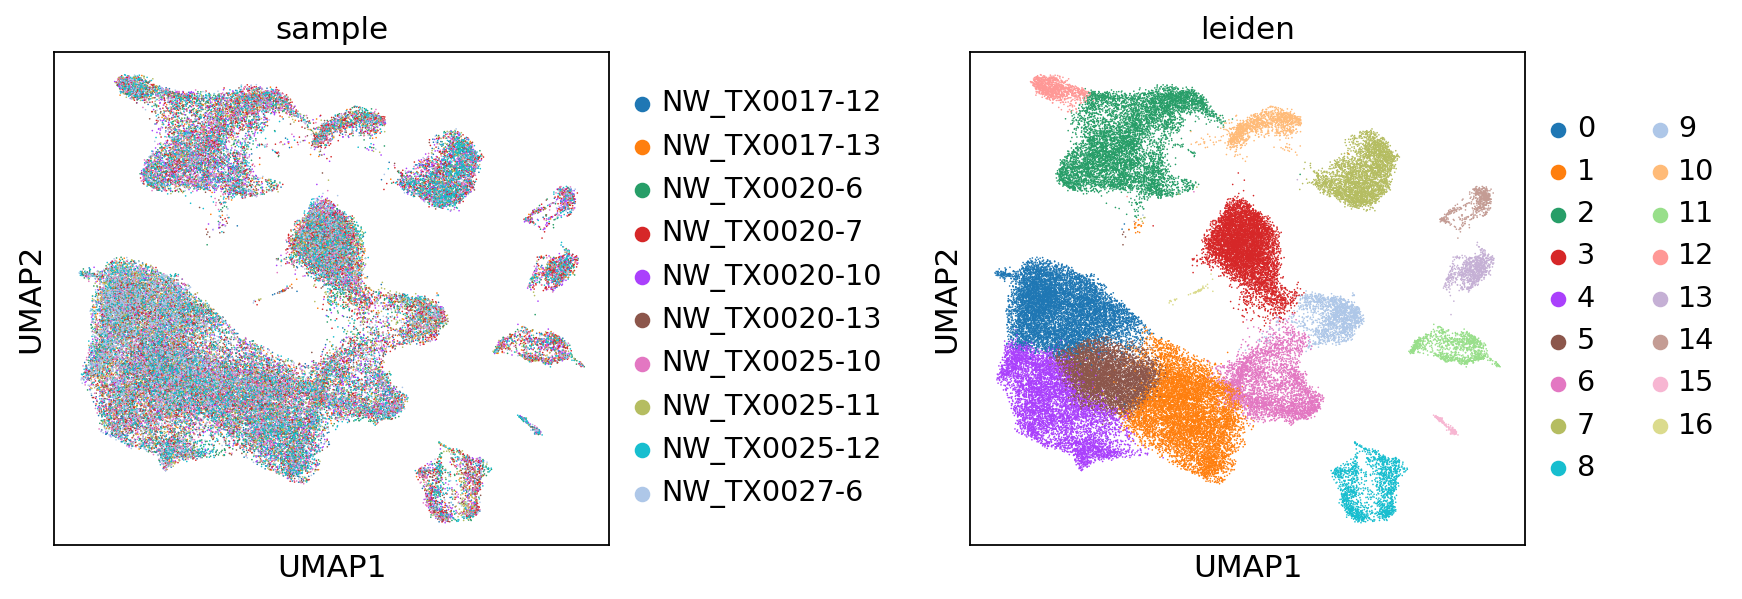

In [ ]:
sc.tl.paga(adata_exc_IT)
sc.pl.paga(adata_exc_IT, plot=False,show =False,use_raw=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_exc_IT,init_pos='paga')
sc.pl.umap(adata_exc_IT, color=["sample","leiden"], cmap="tab20",show=False,wspace=0.5)

In [ ]:
adata_exc_IT

AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'sample_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_exc_IT.obs['leiden'].value_counts()

leiden
0     8434
1     7882
2     7106
3     6378
4     6157
5     5472
6     3535
7     3195
8     1648
9     1568
10    1249
11    1052
12    1010
13     849
14     563
15     181
16      43
Name: count, dtype: int64

In [ ]:
adata_exc_IT = adata_exc_IT[adata_exc_IT.obs['leiden'] != '17',:]
adata_exc_IT

View of AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'sample_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
#adata.uns['leiden'] = adata_exc_IT.uns['leiden']
#adata.uns['leiden_colors'] = adata_exc_IT.uns['leiden_colors']
adata.obs['leiden'] = adata_exc_IT.obs['leiden']
#adata.obs['leiden_colors'] = adata_exc_IT.obs['leiden_colors']

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: xlabel='leiden', ylabel='pct_counts_ribo'>

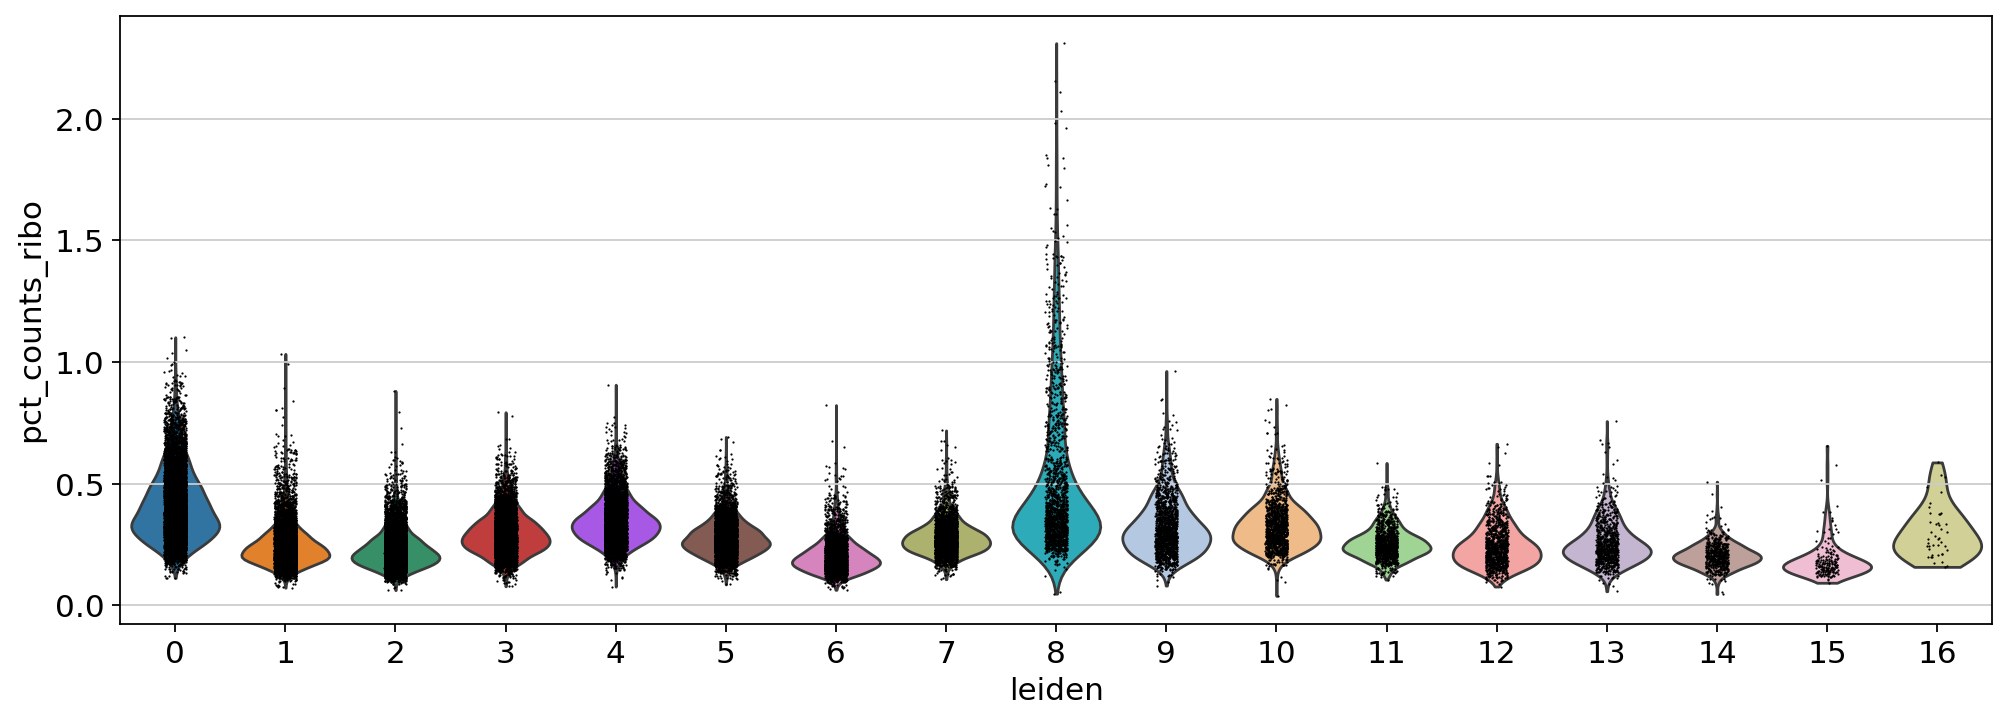

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
sc.pl.violin(adata, 'pct_counts_ribo',groupby="leiden", show=False,ax=axs)

In [ ]:
L2_3_IT = ["CUX2","TAFA1"] #Intratelencephalic projecting
L5_IT = ["RORB","POU6F2"] # LOC105374971 and CUX2 and TAFA1 and no HS3ST2
L6_CT = ["SEMA5A"] #EGFEM1P
L6_IT_Car3 =["ATP10A","RGS12","KLHL1"]
L6_IT =["THEMIS","PDE7B","RGS20"] #LINC00343, LOC101928278 RGS20

In [ ]:
adata_exc_IT

View of AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'sample_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>

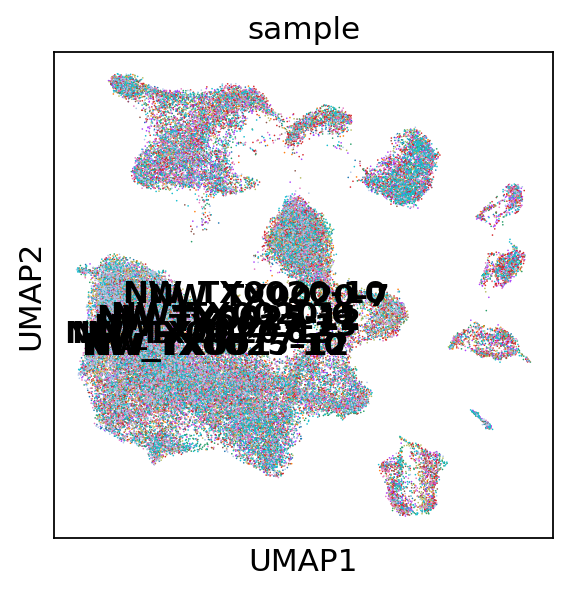

In [ ]:
sc.pl.umap(adata_exc_IT, color="sample", cmap="tab20",show=False)

In [ ]:
adata_exc_IT.varm['PCs']

ArrayView([[-0.05071392, -0.01851502,  0.03393668, ...,  0.00036514,
            -0.00494748,  0.01385562],
           [-0.02236027, -0.03474404,  0.03888249, ...,  0.05610183,
            -0.02297248, -0.06501188],
           [-0.05399599,  0.0041642 , -0.00194857, ...,  0.01691366,
             0.00587715,  0.02585875],
           ...,
           [ 0.01143279,  0.03403451, -0.01485966, ..., -0.04916964,
             0.05784539,  0.00998295],
           [-0.03010197, -0.00680537, -0.01104864, ..., -0.00141072,
            -0.02151591,  0.0082854 ],
           [ 0.0092147 , -0.00238133, -0.00259733, ...,  0.0761841 ,
             0.05584131,  0.09413082]], dtype=float32)

In [ ]:
#pca_dd = pd.DataFrame(np.concatenate(adata_exc_IT.varm['PCs']))
pca_dd = pd.DataFrame(list(map(np.ravel, adata_exc_IT.varm['PCs'])))
pca_dd.index = adata_exc_IT.var_names
pca_dd

0         1         2         3         4         5         6   \
BRINP2 -0.050714 -0.018515  0.033937 -0.018356  0.030836 -0.024123  0.023386   
ADGRL2 -0.022360 -0.034744  0.038882 -0.032817 -0.037359 -0.023212 -0.023031   
KIF26B -0.053996  0.004164 -0.001949  0.008869 -0.000002 -0.004441  0.001296   
DCAF6  -0.033532  0.006688 -0.009214 -0.027965  0.055558  0.006150  0.023822   
PGBD5  -0.023317  0.013870  0.007444 -0.048213  0.035706  0.018663 -0.027814   
...          ...       ...       ...       ...       ...       ...       ...   
C2CD2  -0.011241 -0.020811  0.001078 -0.003804  0.038119 -0.050285 -0.050187   
DSCAM   0.038237  0.018007  0.012375 -0.000424 -0.021382 -0.007434  0.011079   
ERG     0.011433  0.034035 -0.014860  0.077749  0.016791 -0.006670 -0.018222   
NCAM2  -0.030102 -0.006805 -0.011049 -0.021546 -0.041327 -0.000576 -0.087538   
MT-CO2  0.009215 -0.002381 -0.002597  0.004754 -0.005121  0.004073 -0.004805   

              7         8         9   ...        40        41        42  \
BRINP2 -0.032838  0.008481  0.022689  ...  0.015987  0.002744 -0.006678   
ADGRL2  0.014298 -0.002347 -0.035114  ... -0.060479  0.009557 -0.027227   
KIF26B -0.000203  0.026338 -0.050041  ...  0.017691  0.014252  0.016295   
DCAF6  -0.017354  0.022256 -0.001553  ... -0.015165  0.042153 -0.015091   
PGBD5  -0.025648 -0.036034 -0.019767  ... -0.053684 -0.024401 -0.027167   
...          ...       ...       ...  ...       ...       ...       ...   
C2CD2  -0.043180 -0.024286 -0.006117  ... -0.025047  0.008755 -0.042720   
DSCAM   0.097301  0.006095 -0.044385  ...  0.004945 -0.018389 -0.063005   
ERG     0.024407 -0.010805 -0.014161  ...  0.019202 -0.009779 -0.031918   
NCAM2  -0.009386 -0.006554 -0.050091  ... -0.068564  0.016671  0.063797   
MT-CO2  0.011183  0.014416 -0.014464  ...  0.002049  0.082209 -0.100706   

              43        44        45        46        47        48        49  
BRINP2 -0.014747  0.019919  0.015262  0.005991  0.000365 -0.004947  0.013856  
ADGRL2  0.022633  0.030428 -0.062941 -0.010072  0.056102 -0.022972 -0.065012  
KIF26B  0.002997  0.059938  0.013769  0.018708  0.016914  0.005877  0.025859  
DCAF6   0.020729  0.041984 -0.021930  0.003225 -0.009726  0.003476  0.005885  
PGBD5   0.046085  0.000243  0.001017  0.012876 -0.011599 -0.008407 -0.006490  
...          ...       ...       ...       ...       ...       ...       ...  
C2CD2  -0.020788  0.014047  0.057754 -0.011077 -0.023366 -0.045659 -0.020042  
DSCAM   0.010952  0.071654  0.021719  0.043682  0.027954  0.060345  0.027706  
ERG    -0.005563 -0.004914 -0.014244 -0.002252 -0.049170  0.057845  0.009983  
NCAM2   0.057948 -0.000744 -0.047505  0.001599 -0.001411 -0.021516  0.008285  
MT-CO2 -0.012718 -0.078716  0.008366 -0.100680  0.076184  0.055841  0.094131  

[900 rows x 50 columns]

In [ ]:
sc.pp.highly_variable_genes(adata_exc_IT, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor="seurat", batch_key='sample')
print(len(adata_exc_IT.var_names[adata_exc_IT.var.highly_variable]))

extracting highly variable genes


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/cont

    finished (0:00:01)


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:218: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:553: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
209


In [ ]:
adata_exc_IT.var_names[adata_exc_IT.var.highly_variable]

Index(['KIF26B', 'PTPRU', 'AGBL4', 'RALGPS2', 'SPATA6', 'NIBAN1', 'EEIG2',
       'ESRRG', 'MAGI3', 'TNNT2',
       ...
       'LAMP5', 'TOX2', 'DNM2', 'CHST8', 'OLFM2', 'ATP1A3', 'DIP2A', 'PCP4',
       'PDE9A', 'C2CD2'],
      dtype='object', length=209)

In [ ]:
adata_exc_IT

AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'sample_colors', 'leiden_colors', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata_exc_IT.obsm['X_umap'].shape

(56322, 2)

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

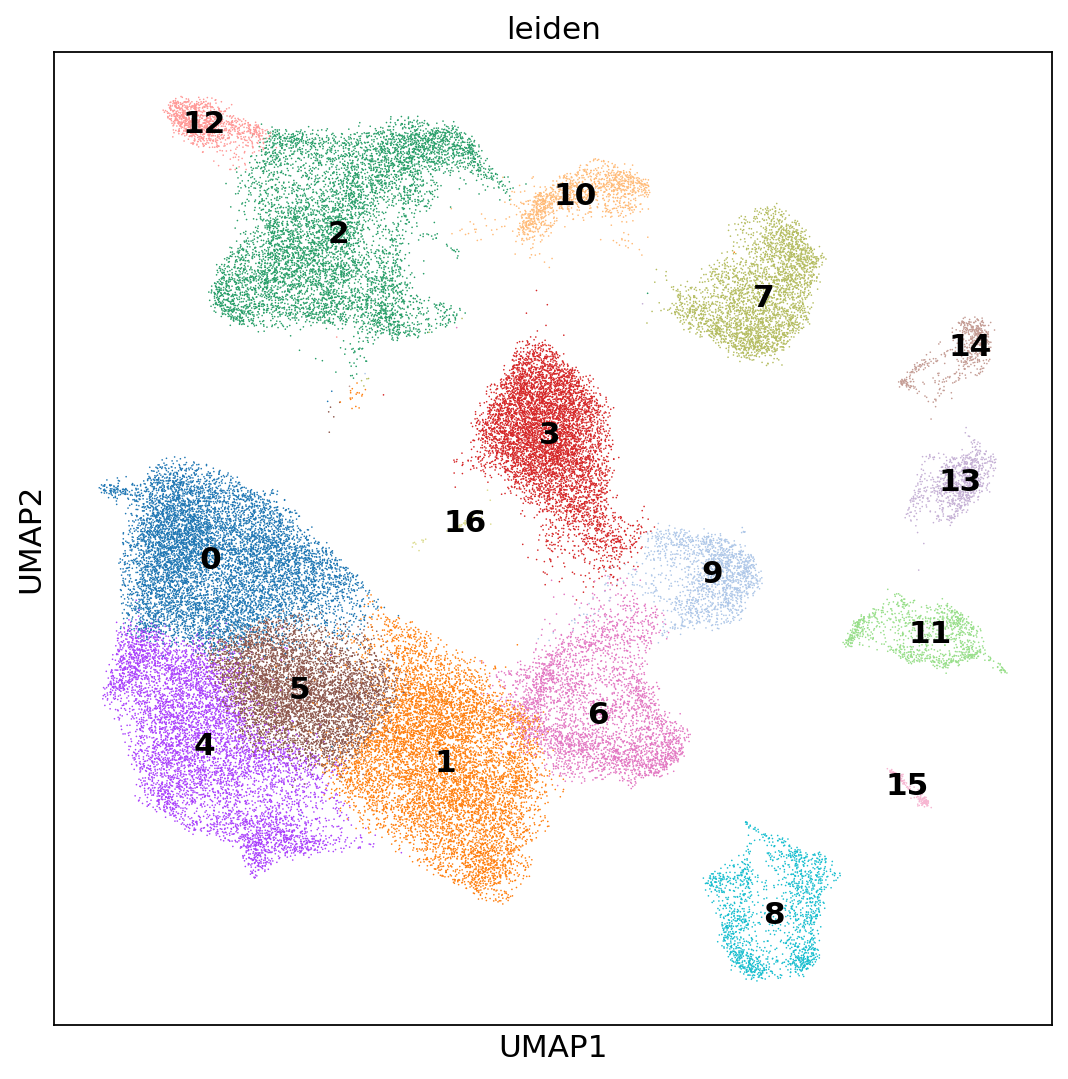

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
sc.pl.umap(adata_exc_IT, color=['leiden'], cmap="tab20",show=False,ax=axs,legend_loc = 'on data')

In [ ]:
#RORB layer 4， 5
#BCL11B, NEFH layer 5
#ETV1 layer 5, 6
#TLE4 layer 5,6
markers = marker_genes + ["CUX1","RORA","DCC"] + ["TAFA2","TAFA5"] + [ "BCL11B"] + ["ETV1"] + ["NEFH"]  + ["TLE4"] + ['FOXP1'] + ['RELN'] + ['HS3ST4']

markers.remove("CARM1P1")
markers.remove("CNR1")
markers.remove("FAM19A1")
markers.remove("FOLH1B")
markers.remove("TWIST2")
markers.remove("FOLH1B")
markers.remove("CHRM2")
markers.remove("CHST9")
markers.remove("IL26")
markers.remove("C1R")
markers.remove("TAFA2")
markers.remove("TAFA5")
markers.remove("THSD4")
markers.remove("FILIP1L")
markers.remove("HTR2A")
markers.remove("SLIT3")
markers. append("HTR2A")
markers.append("OLFML2B")
markers.append("LRMDA")
markers.append("DGKG")
markers.append("PDE8B")
markers.append("GNAL")
markers.append("CBLN2")
markers.append("SLIT3")
markers.append("COL5A2")
markers.append("RUNX1T1")
markers.append("KCTD16")
markers.append("PTPRK")
markers.append("TENM3")
markers.append("CDH9")
markers = np.unique(markers)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

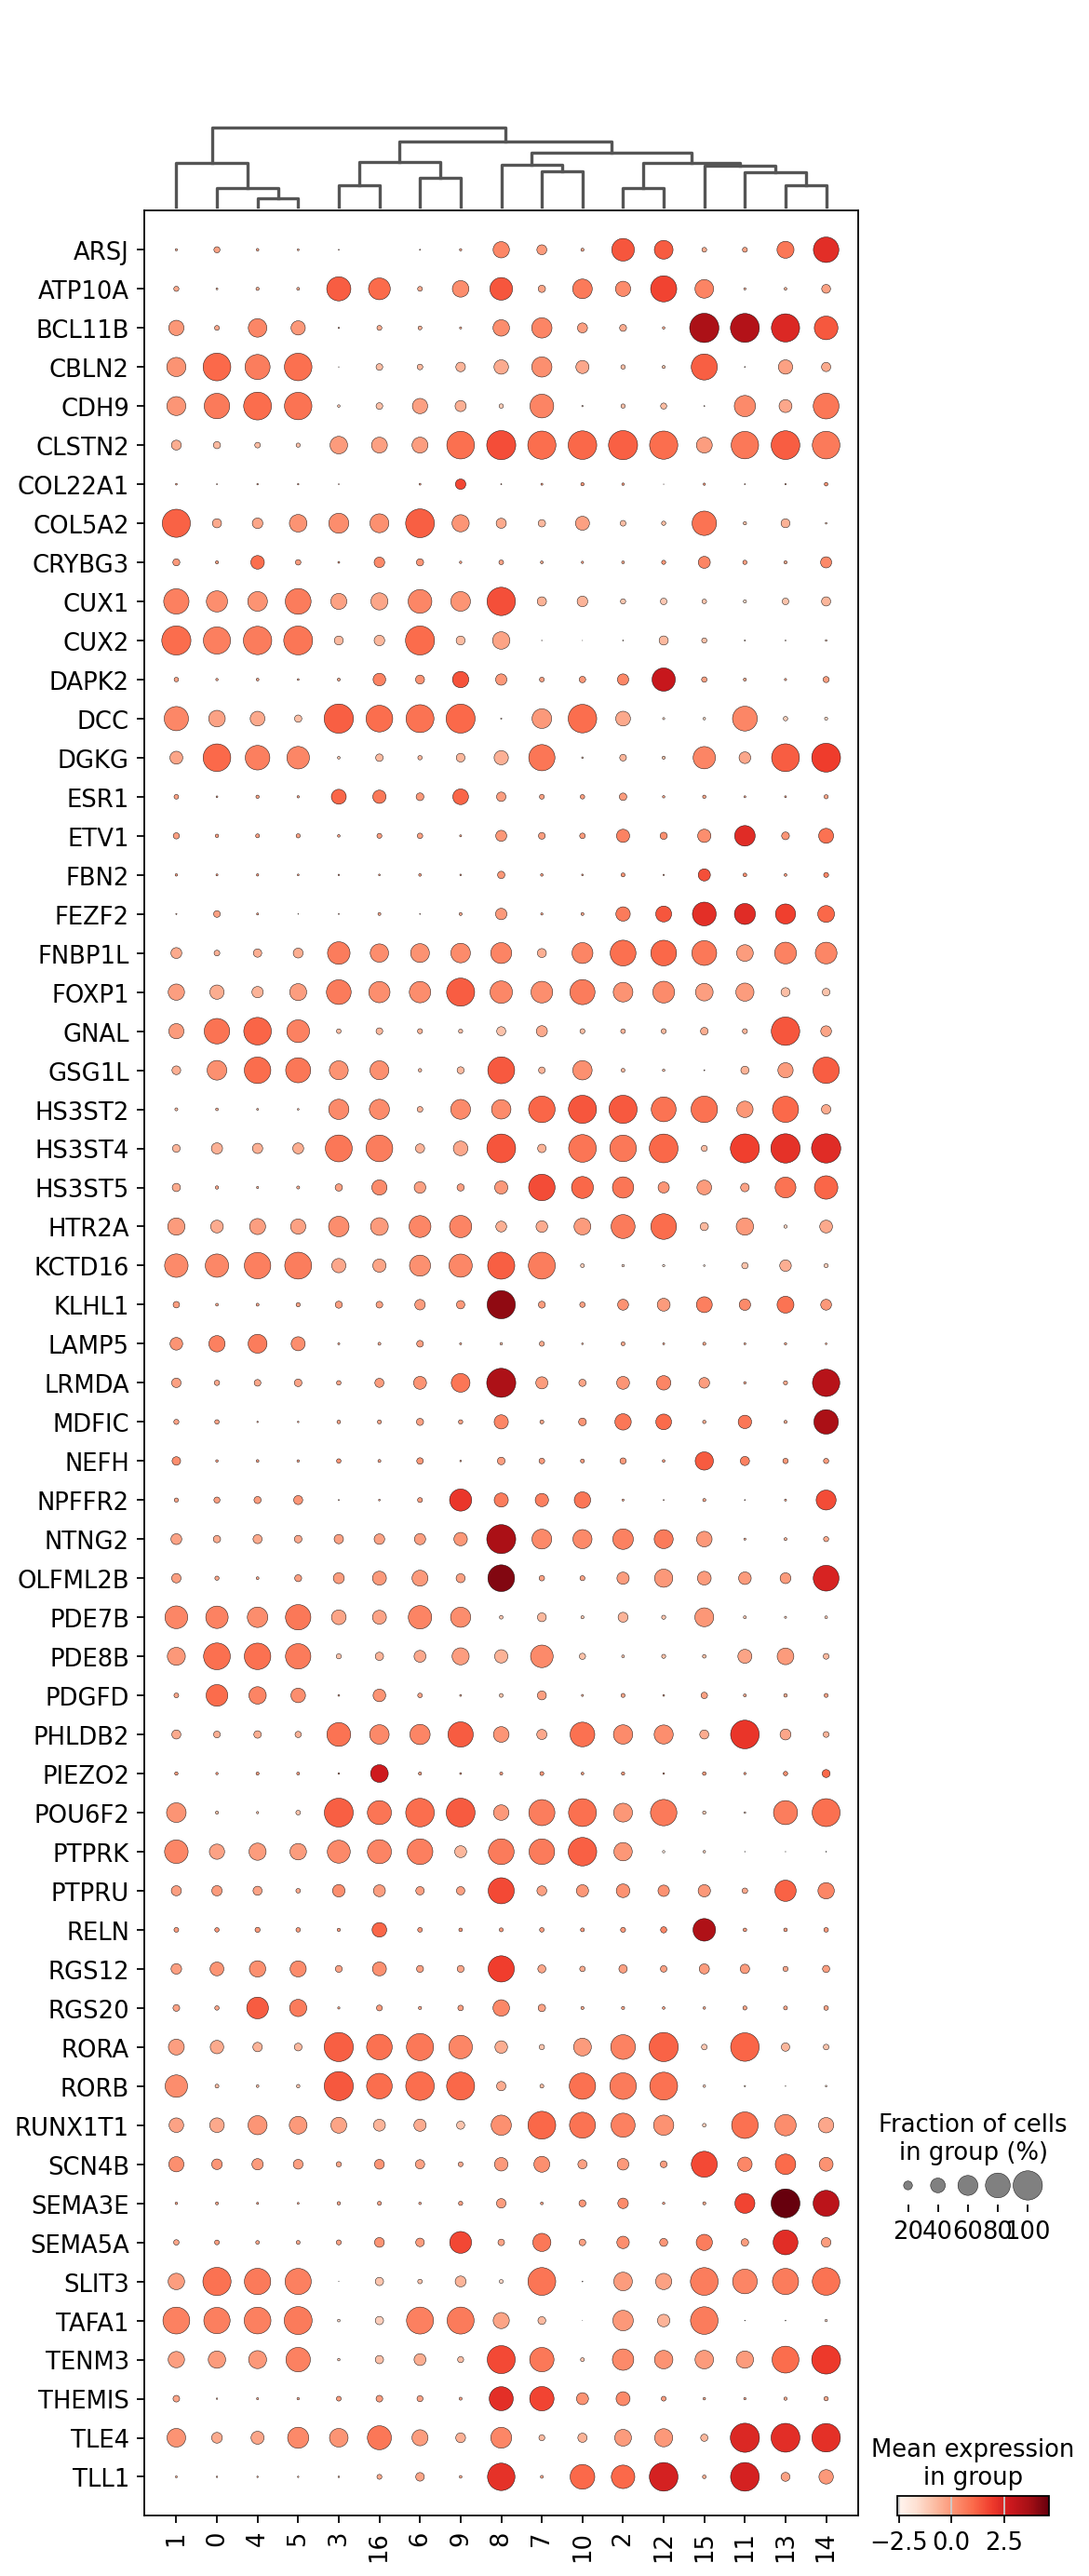

In [ ]:
sc.pl.dotplot(adata_exc_IT, var_names=markers, groupby="leiden", dendrogram=True, swap_axes=True,show=False)

In [ ]:
pd.DataFrame({'gene':adata_exc_IT.var_names}).to_csv(os.path.join(input_DE_dir,"adata_exc_genes.csv"))
output_dir

'/content/drive/MyDrive/LeoDai/Private_Data/GeneSet_Enrichment/chimp'

In [ ]:
L6_IT_gene2 = pd.read_csv(os.path.join(input_DE_dir,"human_L6_IT.de.ovpchimp.txt"),sep="\t",index_col=False,header=0)
L5_IT_gene2 = pd.read_csv(os.path.join(input_DE_dir,"human_L5_IT.de.ovpchimp.txt"),sep="\t",index_col=False,header=None)
L5_IT_gene2.columns = ['gene']
L5_ET_gene2 = pd.read_csv(os.path.join(input_DE_dir,"human_L5_ET.de.ovpchimp.txt"),sep="\t",index_col=False,header=0)
#L5_ET_gene2.columns = ['gene']
L5_ET_gene2
L5_6NP_gene2 = pd.read_csv(os.path.join(input_DE_dir,"human_L56_NP.de.ovpchimp.txt"),sep="\t",index_col=False,header=0)
L5_6NP_gene2

In [ ]:
#cluster0 : 1, 6 : L3_L4_IT? : TAFA1, CUX2, RORB confirmed
#cluster1: 0, 5, 3 : L23_IT : confirmed , PDGFD, CUX2, TAFA1, FAT4

#cluster2: 2, 18 : L4_L5_IT? : RORB
#18 : PIEZO2
#cluster2: 7, 11 : L4_L5_IT?

#cluster3: 10 : L6_IT_Car3 : THEMIS, RGS12, KLHL1 (confirmed DE gene overlap 40%)
#cluster4: 8 : L6_IT : THEMIS confirmed

##cluster5: 13 : L5_L6_novel?

#cluster6: 4,9,12 : RORB, FEZF2, L5-L6_IT

#cluster7: 15 : L6_CT : SEMA5A, SEMA3E

#cluster8: 16 : L6b, MDFIC, SEMA3E

#cluster9: 14 : L56_NP : PHLDB2, SLC24A3, CD36, CARD11, KCNIP1, QRFPR
#cluster10: 17 : RELN : L5_ET : VAT1L, DNAI1

L3_L4_IT = ["1","6"]
L2_L3_IT = ["0","3","5"]
L4_L5_IT = ["2","7","11","18"]
L6_IT = ["8"]
L6_IT_Car3 = ["10"]
L5_L6_novel = ["13"]
L5_L6_IT = ["4","9","12"]
L6_CT = ["15"]
L6b = ["16"]
L56_NP = ["14"]
L5_ET = ["17"]


In [ ]:
adata_exc_IT.obs['DE_subclass'] = np.empty([adata_exc_IT.n_obs], dtype=str)
for idx,i in enumerate(L2_L3_IT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L2_L3_IT'
for idx,i in enumerate(L3_L4_IT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L3_L4_IT'
for idx,i in enumerate(L4_L5_IT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L4_L5_IT'
for idx,i in enumerate(L6_IT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L6_IT'
for idx,i in enumerate(L6_IT_Car3):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L6_IT_Car3'
for idx,i in enumerate(L5_L6_novel):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L5_L6_novel'
for idx,i in enumerate(L5_L6_IT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L5_L6_IT'
for idx,i in enumerate(L6_CT):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L6_CT'
for idx,i in enumerate(L6b):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L6b'
for idx,i in enumerate(L56_NP):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L56_NP'
for idx,i in enumerate(L5_ET):
  adata_exc_IT.obs.loc[adata_exc_IT.obs.leiden == i, 'DE_subclass'] = 'L5_ET'

In [ ]:
adata_exc_IT.write_h5ad(os.path.join(input_DE_dir,"chimp_exc_DE_subclass.h5ad"),compression="gzip")

In [ ]:
adata_exc_raw = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_raw_filt_norm_subclass.h5ad"))
adata_exc_raw

AnnData object with n_obs × n_vars = 56322 × 20189
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
adata_exc_IT = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_DE_subclass.h5ad"))
adata_exc_IT

AnnData object with n_obs × n_vars = 56322 × 900
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'subclass', 'cluster_label', 'leiden', 'DE_subclass'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'dendrogram_leiden', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata_exc_raw.obs['DE_subclass'] = adata_exc_IT.obs['DE_subclass']

In [ ]:
cellinfo_exc=pd.DataFrame({"cell_id":adata_exc_raw.obs_names,"subclass":adata_exc_raw.obs['DE_subclass'],"batch":adata_exc_raw.obs["sample"]})
#cellinfo
cellinfo_exc.to_csv(os.path.join(input_DE_dir,"chimp_cellinfo_exc_DE_subclass.txt"),sep="\t", index=False)
#pd.DataFrame(adata.X).to_csv(os.path.join(output_dir,"chimp_raw_counts.txt"),sep="\t")
#M=adata.X.power(-1)
#M.A
sparse.save_npz(
     os.path.join(input_DE_dir, "chimp_exc_raw_counts_DE_subclass.npz"),
     sparse.csr_matrix(adata_exc_raw.X)
     )

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: xlabel='leiden', ylabel='pct_counts_mt'>

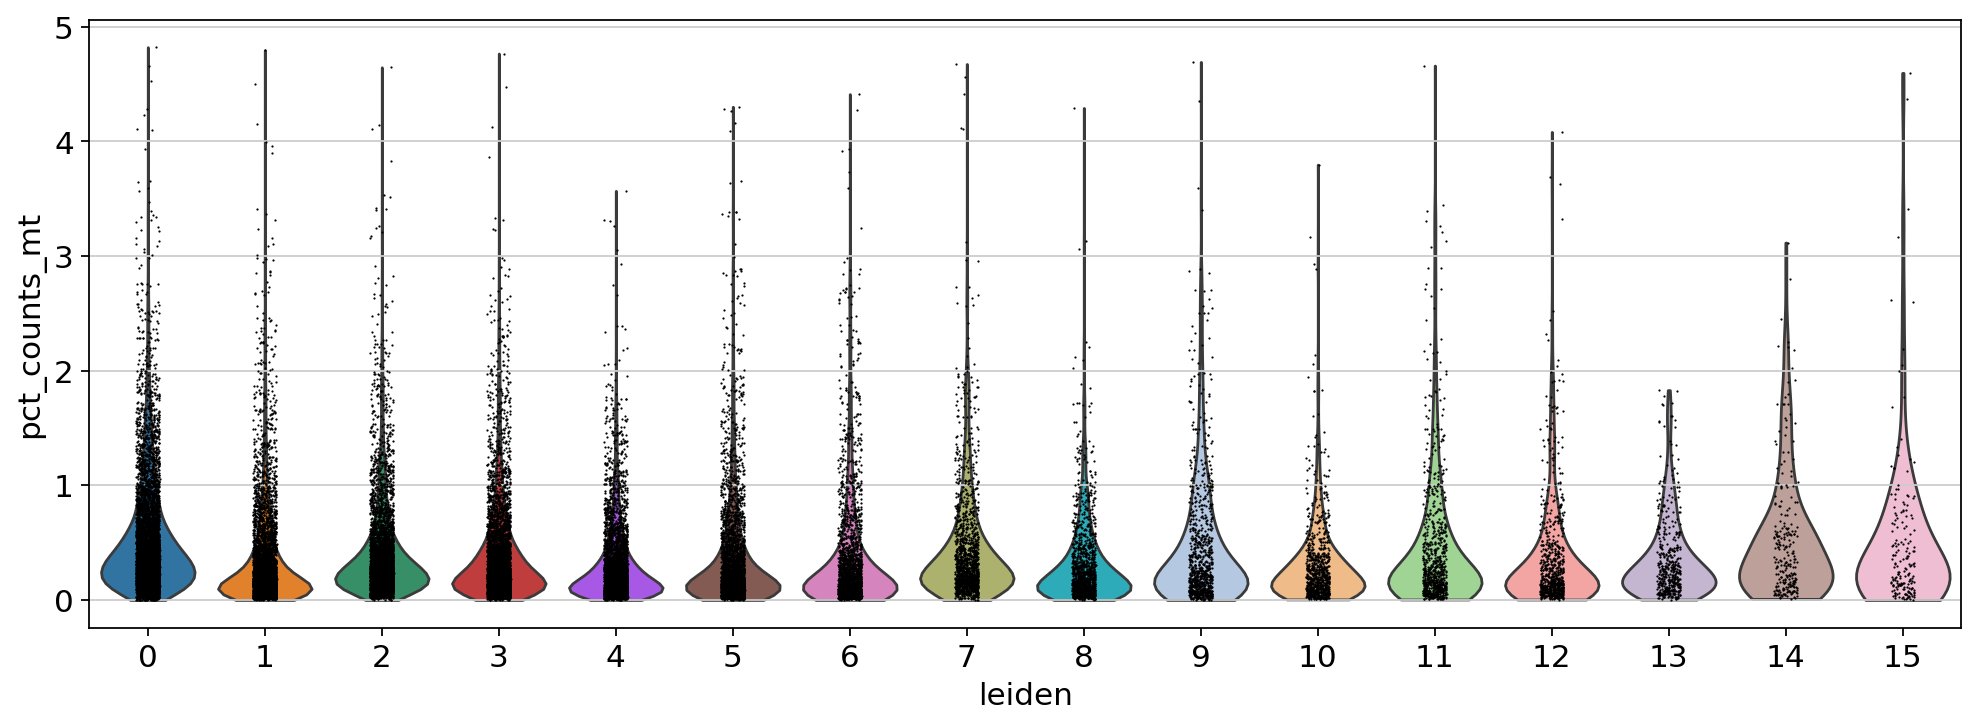

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(15,5))
sc.pl.violin(adata_exc_IT, 'pct_counts_mt',groupby="leiden", show=False,ax=axs)

In [ ]:
#exc celltype umaps
for i in adata_exc.obs['subclass'].unique():
  adata_subclass = adata_exc[adata_exc.obs.subclass == i,:]
  sc.tl.pca(adata_subclass, svd_solver='arpack')
  sc.pp.neighbors(adata_subclass, n_neighbors=10, n_pcs=30)
  sc.tl.umap(adata_subclass)
  sc.pl.umap(adata_subclass, color=['cluster_label'], cmap="tab20",show=False)
  plt.savefig(os.path.join(output_fig_dir + "/exc_celltype","umap_exc_subtype" + i + ".png"))

In [ ]:
#inh celltype umaps
for i in adata_inh.obs['subclass'].unique():
  adata_subclass = adata_inh[adata_inh.obs.subclass == i,:]
  sc.tl.pca(adata_subclass, svd_solver='arpack')
  sc.pp.neighbors(adata_subclass, n_neighbors=10, n_pcs=50)
  sc.tl.umap(adata_subclass)
  sc.pl.umap(adata_subclass, color=['cluster_label'], cmap="tab20",show=False)
  plt.savefig(os.path.join(output_fig_dir + "/inh_celltype","umap_inh_subtype" + i + ".png"))

In [ ]:
adata_mask = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_DE_subclass.h5ad"))
adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_raw_filt_norm_subclass.h5ad"))
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [ ]:
adata = adata[adata.obs_names.isin(adata_mask.obs_names),:]
adata.obs["DE_subclass"] = adata_mask.obs["DE_subclass"]

<ipython-input-48-e1097cb40c92>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["DE_subclass"] = adata_mask.obs["DE_subclass"]


In [ ]:
subdir = "exc_subclass_DE"
DE_genes = dict()
celltype_list = []
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_top_gene_adjPval05_FC1.4.tsv"):
    celltype = file[0:file.find("limma")-1]
    print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
subdir = "exc_subclass_DE"
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  #find cell type top DE gene output txt file
  if file.endswith("_top_gene_adjPval05_FC1.4.tsv"):
    cellclass = file[0:file.find("limma")-1]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    #print(cellclass)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if key == cellclass:
        print(key)
        print(cellclass)
        DE_genes[key].extend(de_genes_df.index[0:5])

['VWC2L', 'TSHZ2', 'GOLIM4', 'RORB', 'POU6F2']
L4_L5_IT:5
['NFIA', 'THEMIS', 'HS3ST5', 'GRIK4', 'ADAMTS16']
L6_IT:5
['CUX2', 'PDZD2', 'RASGRF2', 'PRKCA', 'CBLN2']
L2_L3_IT:5
['OLFML2B', 'KLHL1', 'NTNG2', 'MCTP2', 'SNTB1']
L6_IT_Car3:5
['PCSK5', 'ZFHX3', 'COL25A1', 'HCRTR2', 'MDFIC']
L6b:5
['ERG', 'RXFP2', 'ADGRG6', 'ST8SIA2', 'RELN']
L5_ET:5
['SEMA3E', 'LGR6', 'MCC', 'ADAMTSL1', 'RYR3']
L6_CT:5
['HTR2C', 'NXPH2', 'ROR1', 'LHFPL3', 'KCNIP1']
L56_NP:5
['HS3ST2', 'RXFP1', 'CLSTN2', 'PRUNE2', 'CHN2']
L5_L6_IT:5


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


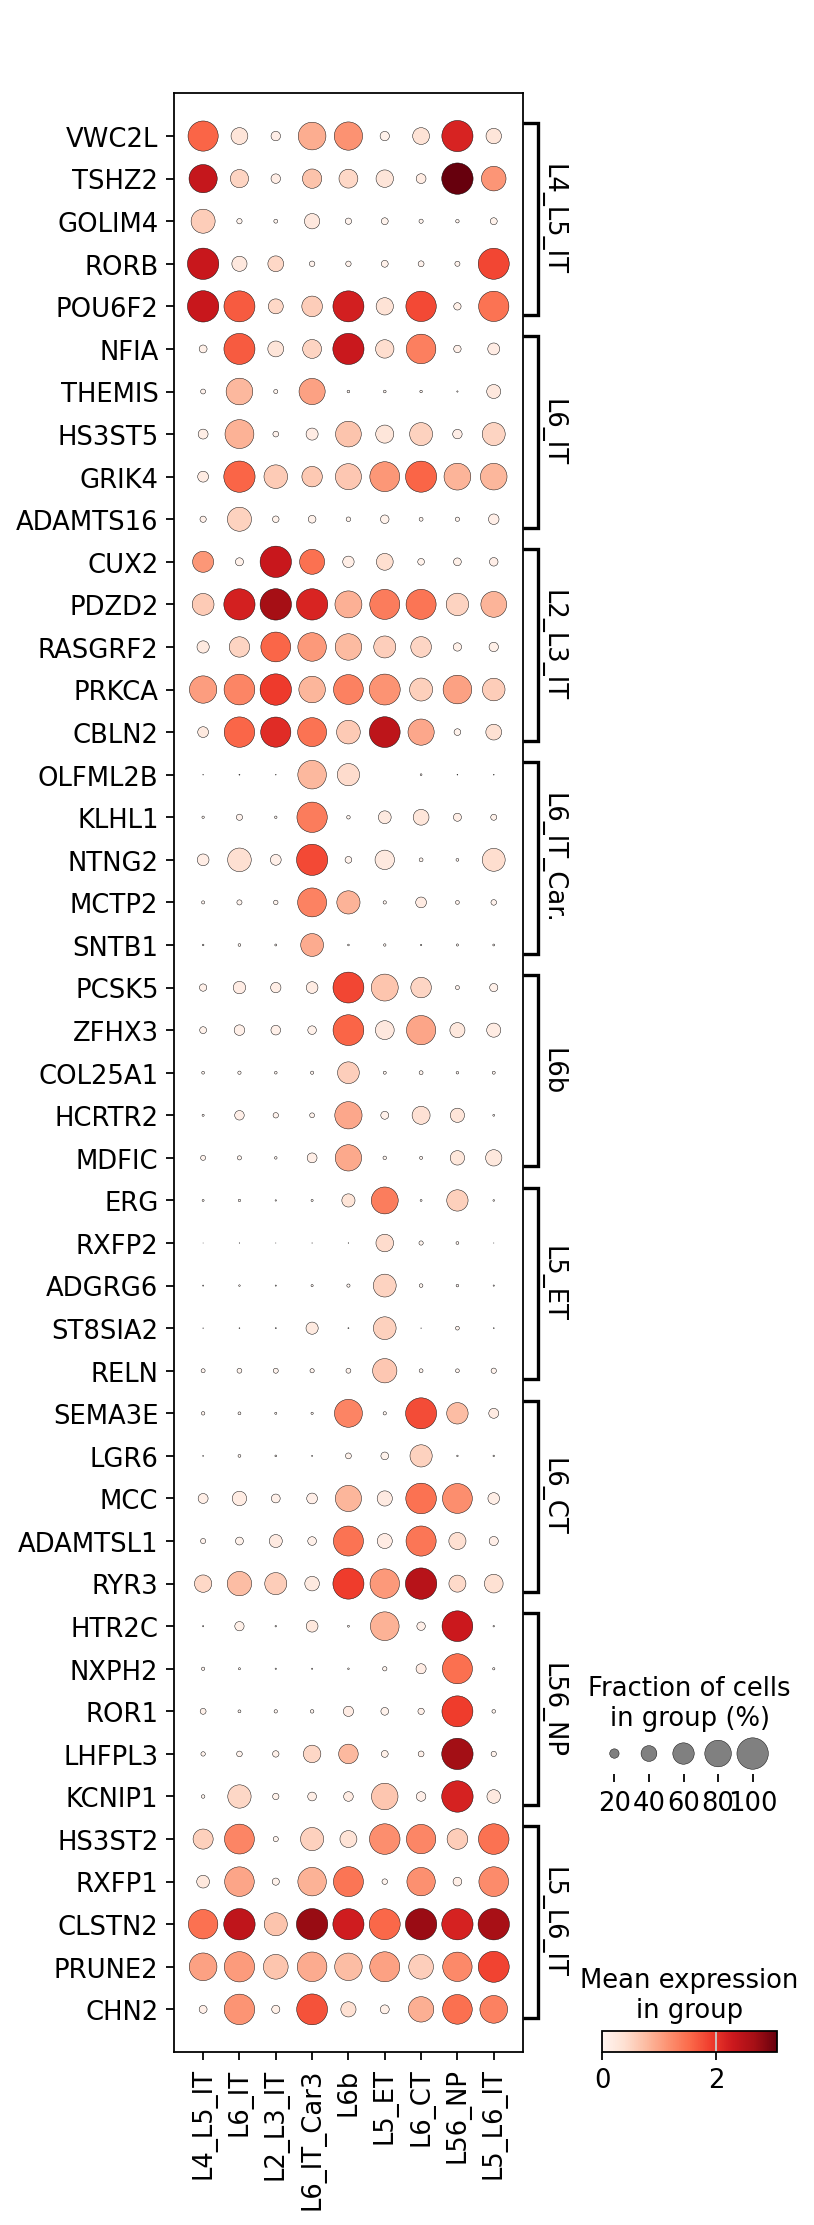

<Figure size 320x320 with 0 Axes>

In [ ]:
genelist = []
for key, value in DE_genes.items():
  print(value)
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)
  genelist.append(value)
  #adata = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
  #sc.pp.normalize_total(adata, target_sum=1e4)
  #sc.pp.log1p(adata)
  #print(adata)

sc.pl.dotplot(adata, var_names=DE_genes, groupby="DE_subclass", categories_order=list(DE_genes.keys()), dendrogram=False, swap_axes=True)
plt.savefig(os.path.join(input_DE_dir,"chimp_dotplot"+key+"_by_DE_top5_genes.png"))

In [ ]:
#celltype dotplot
#notice the exc subclass cluster labels were updated using DE genes for clustering
# raw filt norm h5data is not up to date in terms of the cluster label.

In [ ]:
adata_mask = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_DE_subclass.h5ad"))
adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_raw_filt_norm_subclass.h5ad"))

In [ ]:
adata = adata[adata.obs_names.isin(adata_mask.obs_names),:]
adata.obs["cluster_label"] = adata_mask.obs["cluster_label"]

In [ ]:
adata.obs['DE_subclass'] = adata_mask.obs['DE_subclass']

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
#DE analysis didn't consider small L6_IT clusters, L6_IT_2, L6_IT_3, ...L6_IT8, and L6b_2 and L6b_3

subdir = "exc_celltype_DE"
DE_genes = dict()
celltype_list = []
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("limmatrend_Cov_top_gene_adjPval05_FC1.4.tsv"):
    celltype = file[0:file.find("limma")-1]

    print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []

In [ ]:
subdir = "exc_celltype_DE"
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  #find cell type top DE gene output txt file
  if file.endswith("_top_gene_adjPval05_FC1.4.tsv"):
    cellclass = file[0:file.find("limma")-1]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    print(cellclass)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,subdir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    #print(de_genes_df.index[0:5])

    if cellclass in DE_genes.keys():
        DE_genes[cellclass].extend(de_genes_df.index[0:5])
    else:
        print(cellclass + " not found")



In [ ]:
genelist = []
for key, value in DE_genes.items():
  print(value)
  print(key)
  print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,subdir,key+"_DE_genes_top5.tsv"),sep="\t",index=False)
  genelist.append(value)
  #adata = sc.read_h5ad(os.path.join(input_DE_dir,"rat_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
  #sc.pp.normalize_total(adata, target_sum=1e4)
  #sc.pp.log1p(adata)
  #print(adata)

print(DE_genes.keys())
sc.pl.dotplot(adata, var_names=DE_genes, groupby="cluster_label", dendrogram=False, swap_axes=True)
plt.savefig(os.path.join(input_DE_dir,"chimp_dotplot_celltype"+key+"_by_DE_top5_genes_v2.png"))

In [ ]:
#top 5 DE genes, sorted by log FC
subdir = "exc_subclass_DE"
celldir = "exc_celltype_DE"

DE_genes = dict()
celltype_list = []
overlap_genes = dict()
for file in os.listdir(os.path.join(input_DE_dir,subdir)):
  if file.endswith("_Cov.tsv") :
    celltype = file[0:file.find("limmatrend")-1]
    #print(celltype)
    celltype_list.append(celltype)
    DE_genes[celltype] = []
    overlap_genes[celltype] = []

for file in os.listdir(os.path.join(input_DE_dir,celldir)):
  #find cell type top DE gene output txt file
  #if file.endswith("Cov.tsv"):
  if file.endswith("limmatrend_Cov_adjPval05_FC1.4.tsv"):
    celltype = file[0:file.find("limmatrend")-1]#.split("_")
    #celltype = "_".join(celltype_name_list[0:len(celltype_name_list)])

    #print(celltype)
    #print(file)
    de_genes_df = pd.read_csv(os.path.join(input_DE_dir,celldir,file),sep="\t",header=0,index_col=0)
    de_genes_df.index.name = "gene"
    de_genes_df.sort_values(by="logFC",ascending=False,inplace=True)
    #print(de_genes_df.index[0:5])
    for key in DE_genes.keys():
      if celltype.startswith(key):
        #print(key)
        #remove genes that appear in more than one cell type class
        A= set(DE_genes[key])
        B= set(de_genes_df.index[0:10])
        B = B.difference(set(overlap_genes[key]))

        A_B = A.difference(B)
        B_A = B.difference(A)
        if len(A) == 0:
          overlap_genes[key].extend(B)
        else:
          overlap_genes[key].extend(list(A.intersection(B)))

        DE_genes[key] = list(A_B) + list(B_A)
        #DE_genes[key].extend(list(de_genes_df.index[0:10]))
        #print(DE_genes[key])
    #DE_genes[celltype].extend(de_genes_df.gene)
#print(DE_genes.keys())
#print(DE_genes.values())
for key, value in DE_genes.items():
  #print(value)
  #print(key + ":" + str(len(value)))
  pd.DataFrame({'gene':np.unique(value)}).to_csv(os.path.join(input_DE_dir,celldir,key+"_DE_genes_logFC_top10.tsv"),sep="\t",index=False)

  if key != "L56_NP" and key != "L6_CT":
    #adata = sc.read_h5ad(os.path.join(input_DE_dir,"chimp_exc_"+key+"_raw_filt_norm_subclass.h5ad"))
    adata_sub = sc.read_h5ad(os.path.join(input_DE_dir,subdir, key+"_raw.h5ad"))
    sc.pp.normalize_total(adata_sub, target_sum=1e4)
    sc.pp.log1p(adata_sub)
    print(value)
    print(key)
  #sc.pl.dotplot(adata, var_names=DE_genes, groupby="subclass", categories_order=list(DE_genes.keys()), dendrogram=False, swap_axes=True)
    sc.pl.dotplot(adata_sub, var_names=np.unique(value), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)
    plt.savefig(os.path.join(input_DE_dir,"rat_dotplot"+key+"_by_DE_top5_genes_v2.png"))

In [ ]:
#using scanpy rank genes to select marker genes
adata_sub = sc.read_h5ad(os.path.join(input_DE_dir,subdir, "L2_L3_IT_raw.h5ad"))
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.tl.rank_genes_groups(adata_sub, "cluster_label", method="wilcoxon")


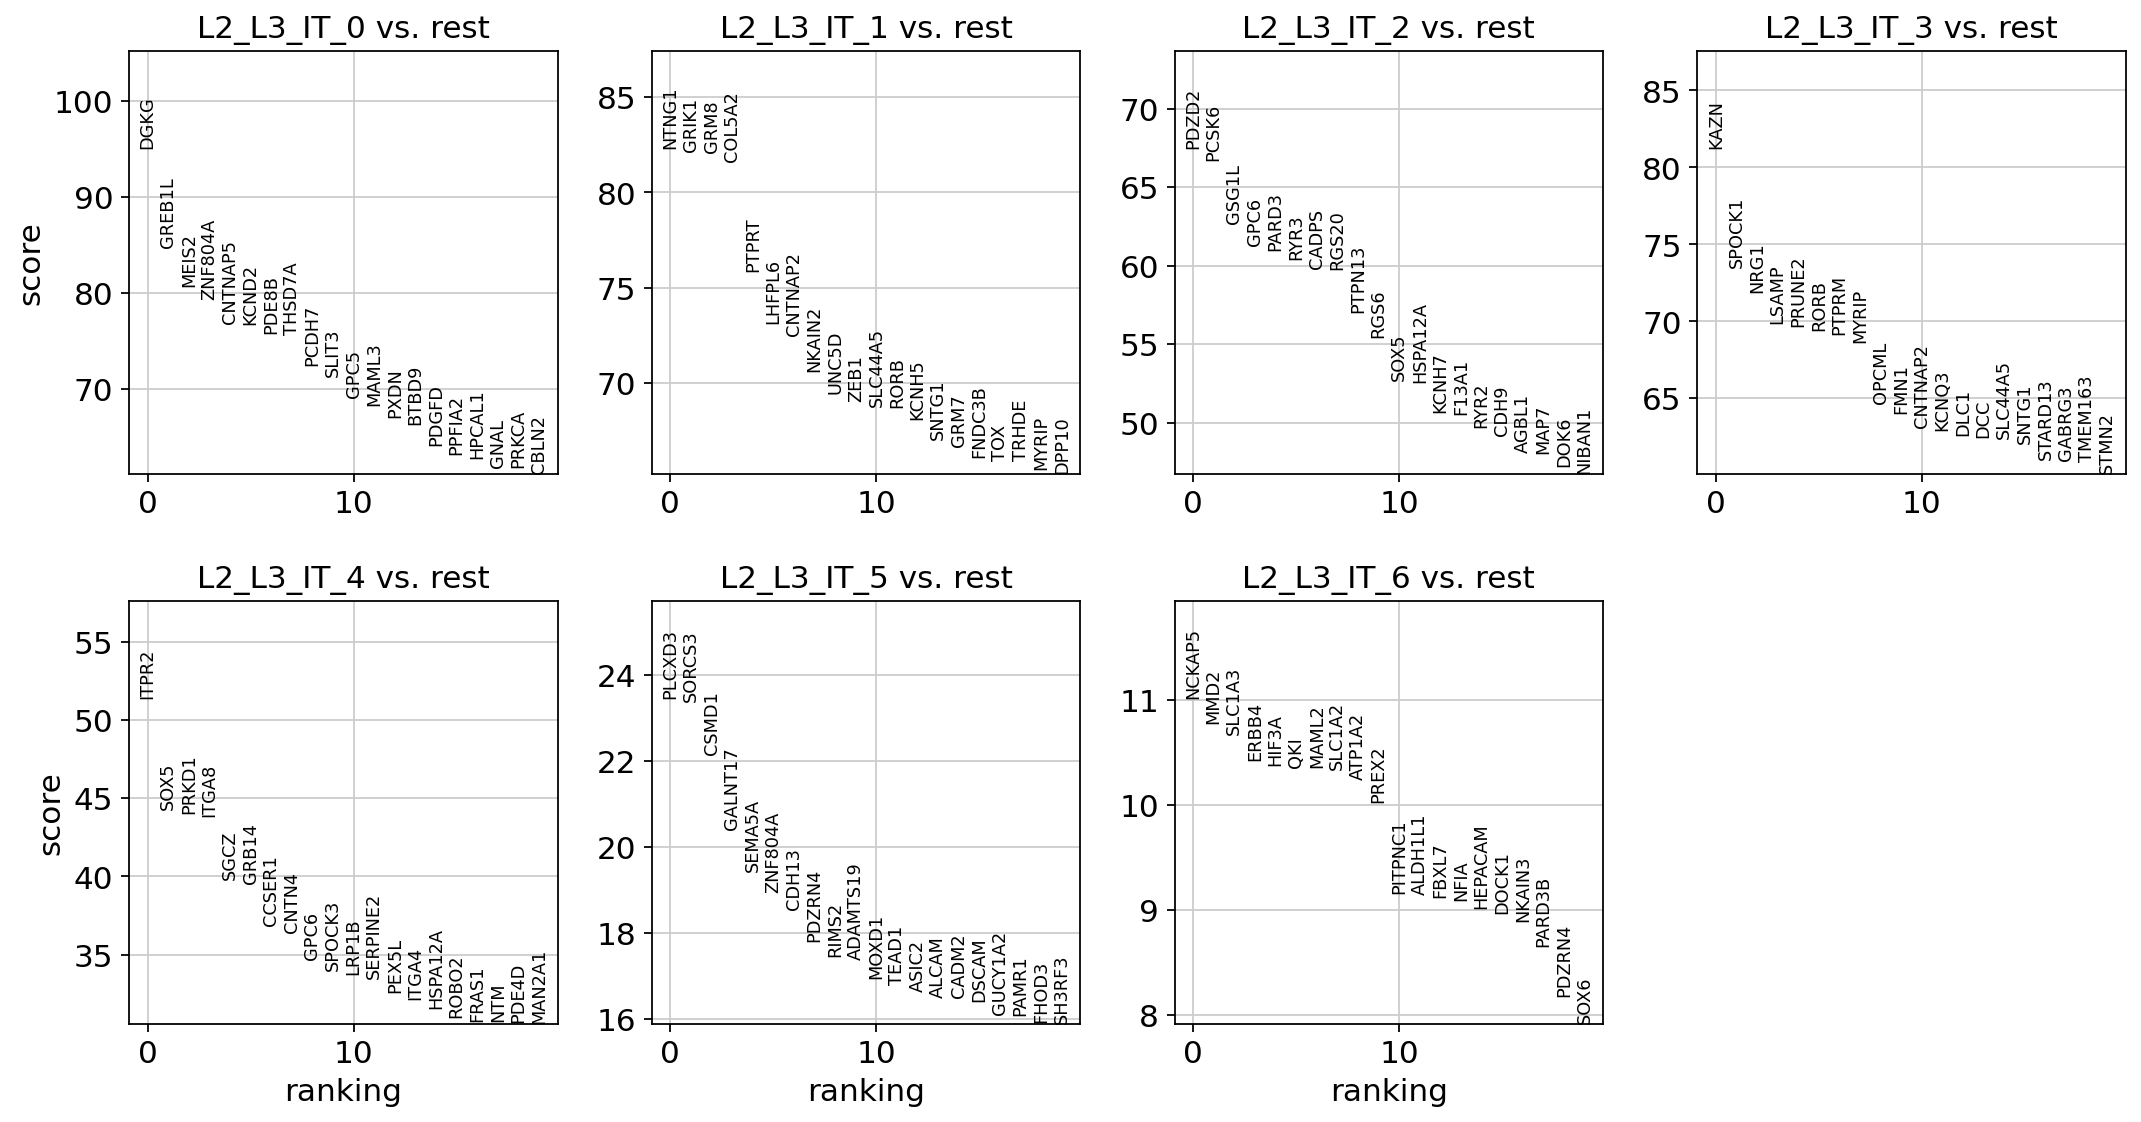

In [ ]:
sc.pl.rank_genes_groups(adata_sub, n_genes=20, sharey=False)

In [ ]:
result = adata_sub.uns["rank_genes_groups"]
groups = result["names"].dtype.names
adata_sub_genes = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

In [ ]:
#top 5 genes
genes = []
for group in groups :
  genes.extend(list(adata_sub.uns["rank_genes_groups"]["names"][group][0:5]))
print(genes)

/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

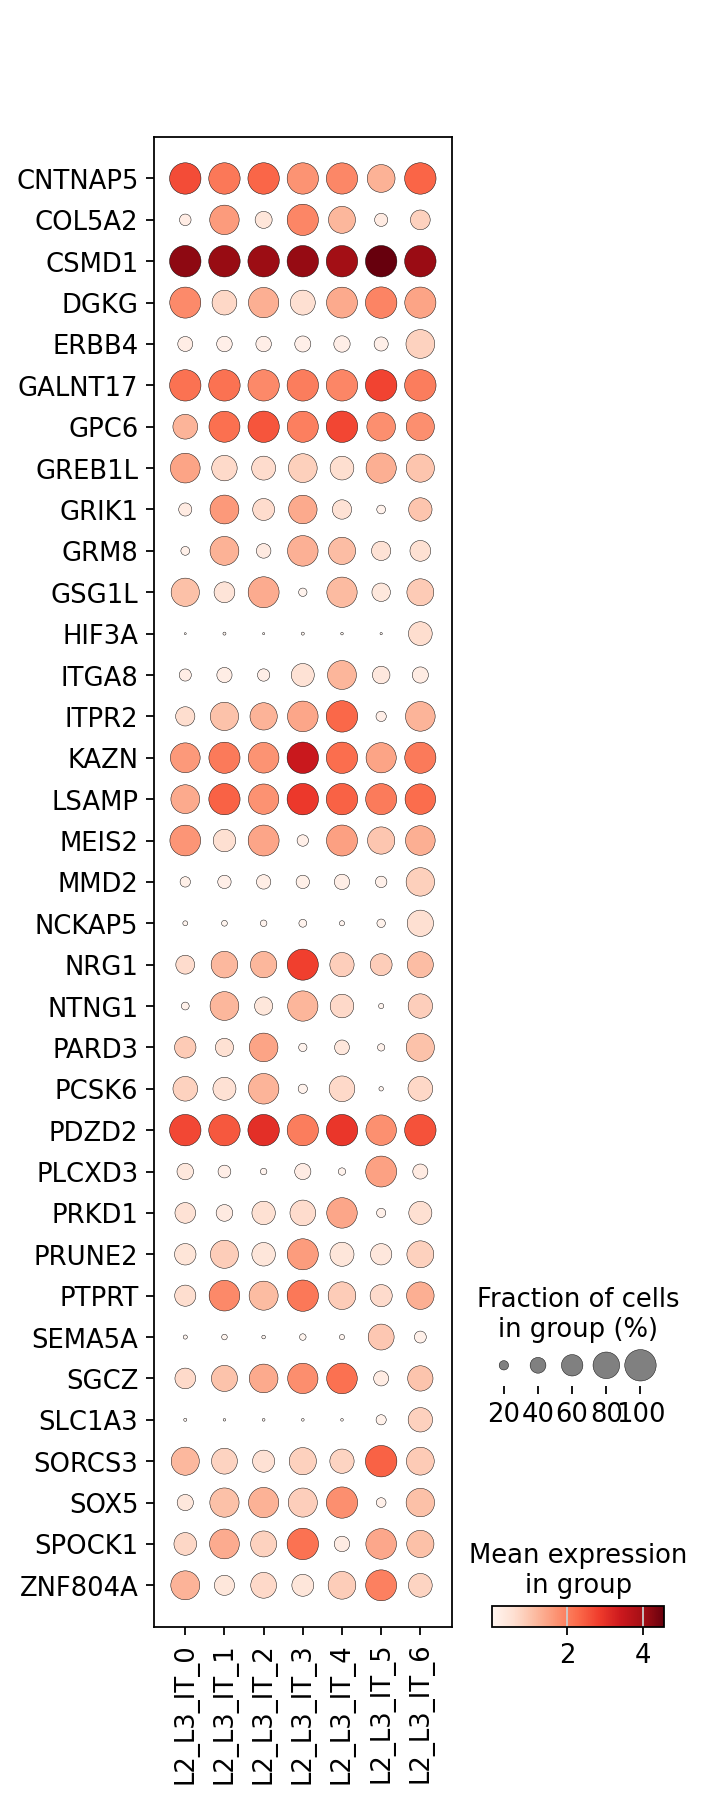

In [ ]:
sc.pl.dotplot(adata_sub, var_names=np.unique(genes), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)

In [ ]:
adata_sub = sc.read_h5ad(os.path.join(input_DE_dir,subdir, "L6_IT_raw.h5ad"))
print(adata_sub.obs['cluster_label'].value_counts())
#select the first two big cluster only
adata_sub = adata_sub[adata_sub.obs.cluster_label.isin(["L6_IT_0","L6_IT_1"])]
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.tl.rank_genes_groups(adata_sub, "cluster_label", method="wilcoxon")

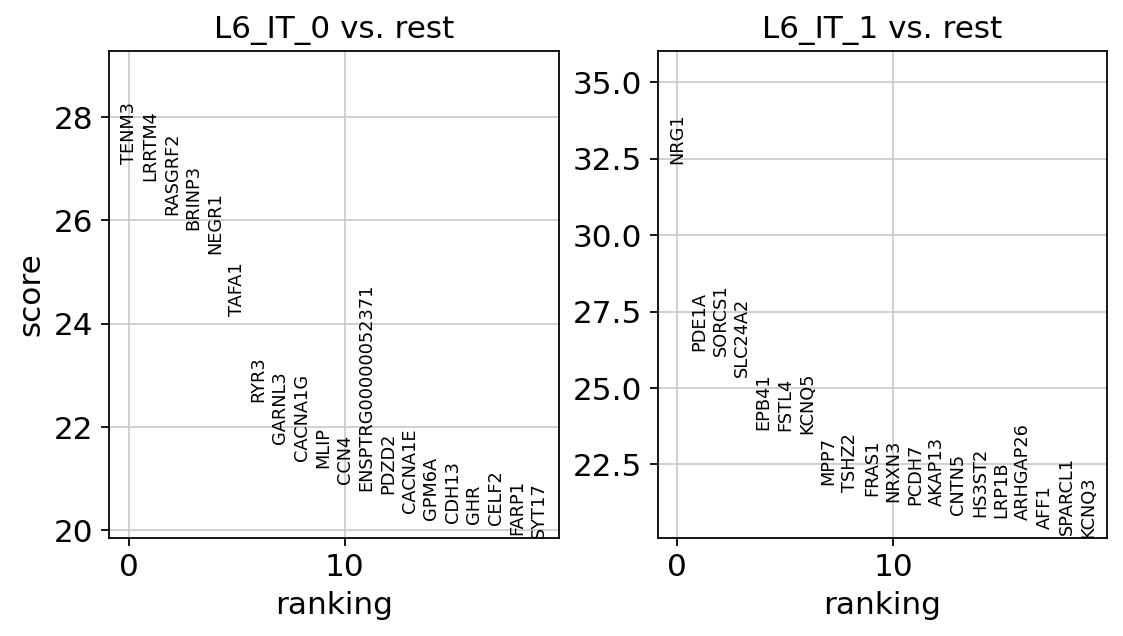

In [ ]:
sc.pl.rank_genes_groups(adata_sub, n_genes=20, sharey=False)

In [ ]:
result = adata_sub.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(8)


In [ ]:
#top 5 genes
genes = []
for group in groups :
  genes.extend(list(adata_sub.uns["rank_genes_groups"]["names"][group][0:8]))
print(genes)

['TENM3', 'LRRTM4', 'RASGRF2', 'BRINP3', 'NEGR1', 'TAFA1', 'RYR3', 'GARNL3', 'NRG1', 'PDE1A', 'SORCS1', 'SLC24A2', 'EPB41', 'FSTL4', 'KCNQ5', 'MPP7']


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

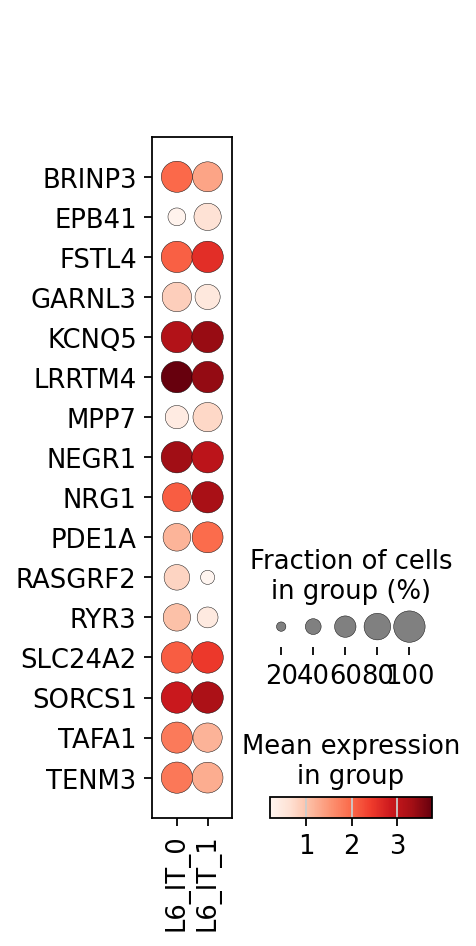

In [ ]:
sc.pl.dotplot(adata_sub, var_names=np.unique(genes), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)

In [ ]:
adata_sub = sc.read_h5ad(os.path.join(input_DE_dir,subdir, "L6b_raw.h5ad"))
print(adata_sub.obs['cluster_label'].value_counts())
#select the first two big cluster only
adata_sub = adata_sub[adata_sub.obs.cluster_label.isin(["L6b_0","L6b_1"])]
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.tl.rank_genes_groups(adata_sub, "cluster_label", method="wilcoxon")

In [ ]:
result = adata_sub.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(8)

In [ ]:
#top 5 genes
genes = []
for group in groups :
  genes.extend(list(adata_sub.uns["rank_genes_groups"]["names"][group][0:8]))
print(genes)

['TRPM3', 'LMO4', 'RYR2', 'GREB1L', 'KCNQ5', 'LSAMP', 'ANO3', 'KCNH7', 'GALNT17', 'KIRREL3', 'MITF', 'CCBE1', 'CSMD3', 'SORCS3', 'LHFPL3', 'RIMS2']


/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

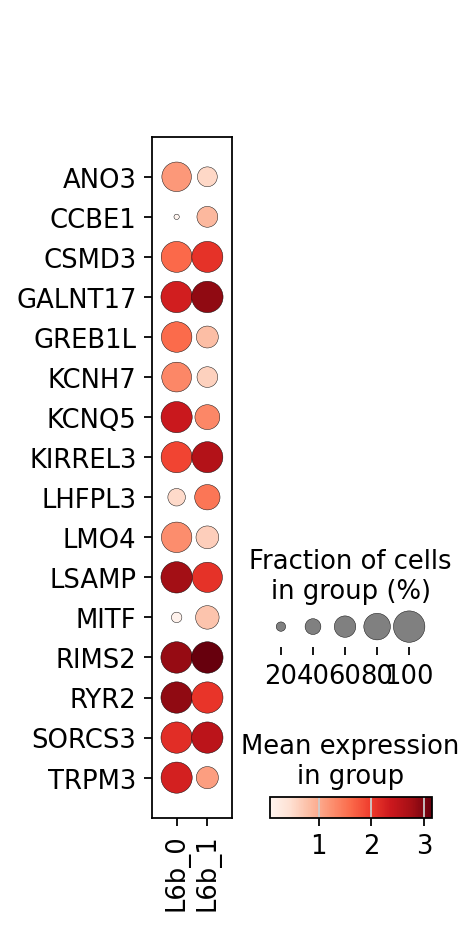

In [ ]:
sc.pl.dotplot(adata_sub, var_names=np.unique(genes), groupby="cluster_label", dendrogram=False, swap_axes=True,show=False)